## Diffusion method: combine item-item and user-user

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection as cv
from sklearn.metrics.pairwise import pairwise_distances
import re
import torch

import networkx as nx
from networkx.algorithms import bipartite

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm

import json

### Read in data

In [2]:
df_movies = pd.read_csv('movies.dat',
                        delimiter='::', engine= 'python', encoding='ISO-8859-1', header=None,
                        names=['movie_id', 'movie_name', 'genre'])

df_users = pd.read_csv('users.dat',
                       delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

df_ratings = pd.read_csv('ratings.dat',
                         delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])

In [3]:
df_movies['year'] = df_movies.movie_name.apply(lambda x: re.findall(r'\(\d{4}\)', x)[0][1:-1])

In [4]:
df_movies.head()

,movie_id,movie_name,genre,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [5]:
df_users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
df_ratings.drop(columns=['time'], inplace=True)

In [7]:
df_ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Add region classification and split into subsets

In [8]:
df_users.zip_code = df_users.zip_code.apply(lambda x: x.split('-')[0]).astype(int)

In [9]:
df_users = pd.merge(df_users, pd.read_csv('ruralcodes.csv'), how='left', left_on='zip_code', right_on='ZIP_CODE')
df_users.drop(columns=['RUCA2', 'ZIP_TYPE', 'ZIP_CODE'], inplace=True)

In [10]:
df_users = df_users[~df_users.STATE.isna()]

In [11]:
df_users = pd.merge(df_users, pd.read_csv('zip_code_database.csv'), how='left', left_on='zip_code', right_on='zip')
df_users.drop(
    columns=['decommissioned', 'primary_city', 'acceptable_cities', 'unacceptable_cities', 'state', 'type', 
             'zip', 'county', 'timezone', 'area_codes', 'world_region', 'country', 'latitude', 'longitude'],
    inplace=True)

In [12]:
census_region_mapping = {
    'WEST': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'HI', 'AK', 'NM', 'AZ'],
    'SOUTH': ['TX', 'OK', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'WV', 
              'VA', 'DC', 'DE', 'MD', 'NC', 'SC', 'GA', 'FL', 'PR'],
    'MIDWEST': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'NORTHEAST': ['PA', 'NY', 'NJ', 'RI', 'CT', 'MA', 'NH', 'VT', 'ME']
}

def match_region(state: str) -> str:
    for k, v in census_region_mapping.items():
        if state in v:
            return k
    return state

In [13]:
df_users['region'] = df_users.STATE.apply(match_region)

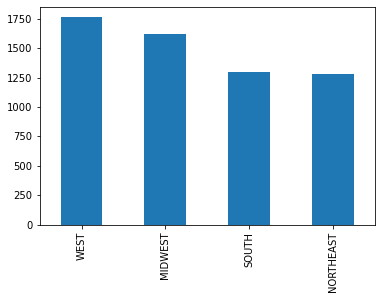

In [14]:
_ = df_users.region.value_counts().plot.bar()

In [15]:
df_users_west = df_users[df_users.region == 'WEST']
df_users_midwest = df_users[df_users.region == 'MIDWEST']
df_users_south = df_users[df_users.region == 'SOUTH']
df_users_northeast = df_users[df_users.region == 'NORTHEAST']

### Build similarity matrix

#### Merge datasets and split into train and test set

In [16]:
df_users_ratings = pd.merge(df_users, df_ratings, how='outer', on='user_id')

In [17]:
df_users_ratings = pd.pivot(df_users_ratings, index='user_id', columns='movie_id', values='rating').fillna(0)

In [18]:
df_users_ratings_train_idx, df_users_ratings_test_idx = cv.train_test_split(df_users_ratings.index, 
                                                                            test_size=0.2, random_state=42)

In [19]:
df_users_ratings_train = df_users_ratings.copy()
df_users_ratings_train.loc[df_users_ratings_test_idx] = 0

In [20]:
df_users_ratings_test = df_users_ratings.copy()
df_users_ratings_test.loc[df_users_ratings_train_idx] = 0

In [21]:
item_user_matrix_train = df_users_ratings_train.to_numpy().T
item_user_matrix_train.shape

(3706, 6040)

In [22]:
item_user_matrix_test = df_users_ratings_test.to_numpy().T
item_user_matrix_test.shape

(3706, 6040)

#### User-user similarity

In [23]:
len_users = item_user_matrix_train.shape[1]
user_similarity = np.ones((len_users, len_users)) - pairwise_distances(item_user_matrix_train.T, metric='cosine')

In [24]:
user_similarity.shape

(6040, 6040)

#### Genre similarity

In [25]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [26]:
df_ratings_movies_train = pd.merge(df_ratings, df_movies, on='movie_id')
df_users_genres_train = df_ratings_movies_train.groupby('user_id').agg({'genre': lambda x: list(x)}).reset_index()

In [27]:
def count_genres(gs: list) -> list:
    gs_dict = dict(zip(genres, len(genres) * [0]))
    for g in gs:
        g_list = g.split('|')
        for sub_g in g_list:
            gs_dict[sub_g] += 1
    return list(gs_dict.values())

In [28]:
df_users_genres_train.genre = df_users_genres_train.genre.apply(count_genres)
user_genre_matrix_train = np.array(df_users_genres_train.genre.tolist())

In [29]:
genre_similarity = np.ones((len_users, len_users)) - pairwise_distances(user_genre_matrix_train, metric='cosine')

In [30]:
genre_similarity.shape

(6040, 6040)

#### Year similarity

In [31]:
years = list(df_movies.sort_values('year').year.unique())

In [32]:
df_users_years_train = df_ratings_movies_train.groupby('user_id').agg({'year': lambda x: list(x)}).reset_index()

In [33]:
def count_years(ys: list) -> list:
    ys_dict = dict(zip(years, len(years) * [0]))
    for y in ys:
        ys_dict[y] += 1
    return list(ys_dict.values())

In [34]:
df_users_years_train.year = df_users_years_train.year.apply(count_years)
user_year_matrix_train = np.array(df_users_years_train.year.tolist())

In [35]:
year_similarity = np.ones((len_users, len_users)) - pairwise_distances(user_year_matrix_train, metric='cosine')

In [36]:
year_similarity.shape

(6040, 6040)

#### Bipartite similarity

In [103]:
movies_str = np.array([str(mid) for mid in df_movies.movie_id.unique()])
df_ratings['movie_id_str'] = df_ratings.movie_id.apply(str)

In [106]:
g = nx.Graph()
g.add_nodes_from(movies_str, bipartite=0)
g.add_nodes_from(np.arange(len_users), bipartite=1)

edges = df_ratings[['movie_id_str', 'user_id']].values
g.add_edges_from(edges)

In [107]:
B = bipartite.overlap_weighted_projected_graph(g, np.arange(len_users))

In [108]:
B_edges = list(B.edges(data=True))

In [109]:
B_similarity = np.zeros((len_users, len_users))

for i, j, weight in B_edges:
    B_similarity[i-1, j-1] = weight['weight']
    B_similarity[j-1, i-1] = weight['weight']

In [110]:
B_similarity.shape

(6040, 6040)

In [111]:
pd.DataFrame(B_similarity).to_csv("B_similarity_uu.csv")

In [37]:
B_similarity = pd.read_csv("B_similarity_uu.csv")
B_similarity = np.array(B_similarity.drop('Unnamed: 0', axis=1))

### Transition matrix

In [38]:
transition_matrix_user = np.zeros((len_users, len_users))
transition_matrix_B = np.zeros((len_users, len_users))
transition_matrix_year = np.zeros((len_users, len_users))
transition_matrix_genre = np.zeros((len_users, len_users))

for i in range(len_users):
    sim_sum = user_similarity[i].sum()
    genre_sum = genre_similarity[i].sum()
    year_sum = year_similarity[i].sum()
    b_sum = B_similarity[i].sum()
    
    for j in range(len_users):
        transition_matrix_user[i,j] = user_similarity[i][j] / sim_sum
        transition_matrix_genre[i,j] = genre_similarity[i][j] / genre_sum
        transition_matrix_year[i,j] = year_similarity[i][j] / year_sum
        transition_matrix_B[i,j] = B_similarity[i][j] / b_sum

In [39]:
item_user_matrix_test.shape

(3706, 6040)

### Prediction

In [40]:
scaler = MinMaxScaler()

In [74]:
def random_walk_predict(ratings: np.array, transition_matrix: np.array, alpha: float) -> np.array:
    x = np.eye(len_users) -alpha * transition_matrix
    
    #Obtain mean of columns as you need, nanmean is convenient.
    col_mean = np.nanmean(x, axis=0)
    #Find indices that you need to replace
    inds = np.where(np.isnan(x))
    #Place column means in the indices. Align the arrays using take
    x[inds] = np.take(col_mean, inds[1])
    print('Start')
    p_tilde = np.linalg.pinv(x)
    print('End')
    final_rating = alpha*np.dot(ratings, np.dot(x, p_tilde))
    scaled_prediction = (scaler.fit_transform(final_rating.T) * 5).T
    return scaled_prediction

In [42]:
def rmse(prediction: np.array, test_data_matrix: np.array) -> float:
    mask = test_data_matrix.nonzero()
    prediction = prediction[mask].flatten()
    truth = test_data_matrix[mask].flatten()
    return sqrt(mean_squared_error(prediction, truth))

In [44]:
def run_grid_search(parameters: list) -> dict:
    results = {}
    for parameter in tqdm(parameters):
        alpha, beta, w1, w2, w3 = parameter
        transition_matrix = beta * (w1 * transition_matrix_user + 
                                    w2 * transition_matrix_year + 
                                    w3 * transition_matrix_B + 
                                    (1 - w1 - w2 - w3) * transition_matrix_genre) + (1 - beta) / len_users
        try:
            prediction = random_walk_predict(item_user_matrix_train, transition_matrix, alpha)
        except:
            continue
        results[parameter] = rmse(prediction, item_user_matrix_test)
    
    return results

In [60]:
alphas = [0.9, 1.0]
betas = [0.6, 0.7, 0.8]
w1s = w2s = w3s = [0.1, 0.2, 0.3, 0.5, 0.6]
weights = [(w1, w2, w3) for w1 in w1s for w2 in w2s for w3 in w3s if w1 + w2 +w3 <= 1 ]
parameters = [(alpha, beta, w1, w2, w3) for alpha in alphas for beta in betas for w1, w2 ,w3 in weights]

In [62]:
len(parameters)

414

In [68]:
from random import sample

In [69]:
results = run_grid_search(sample(parameters, 20))

100%|███████████████████████████████████████████████████| 20/20 [24:34<00:00, 73.70s/it]


In [70]:
alpha, beta, w1, w2, w3 = min(results, key=results.get)
alpha, beta, w1, w2, w3

(1.0, 0.6, 0.5, 0.1, 0.2)

{(0.9, 0.7, 0.1, 0.3, 0.1): 3.7532123598125047,
 (1.0, 0.6, 0.2, 0.5, 0.2): 3.6704508996987855,
 (1.0, 0.6, 0.2, 0.2, 0.3): 3.663482575253007,
 (0.9, 0.8, 0.5, 0.1, 0.1): 3.753212359812503,
 (1.0, 0.6, 0.1, 0.1, 0.1): 3.7020101617977743,
 (1.0, 0.6, 0.5, 0.1, 0.2): 3.621472591162577,
 (0.9, 0.6, 0.1, 0.1, 0.1): 3.7532123598125176,
 (0.9, 0.6, 0.6, 0.2, 0.1): 3.7532123598124727,
 (0.9, 0.7, 0.6, 0.1, 0.2): 3.753212359812481,
 (0.9, 0.8, 0.3, 0.2, 0.1): 3.7532123598124896,
 (0.9, 0.6, 0.3, 0.1, 0.6): 3.7532123598125176,
 (0.9, 0.7, 0.2, 0.6, 0.1): 3.7532123598125047,
 (0.9, 0.7, 0.5, 0.2, 0.2): 3.753212359812511,
 (1.0, 0.6, 0.1, 0.3, 0.1): 3.6995009827203886,
 (0.9, 0.7, 0.2, 0.1, 0.3): 3.7532123598125198,
 (1.0, 0.6, 0.2, 0.5, 0.3): 3.660220532394535,
 (1.0, 0.8, 0.1, 0.3, 0.2): 3.6689644038650013,
 (1.0, 0.6, 0.1, 0.2, 0.2): 3.69057953879165,
 (1.0, 0.8, 0.1, 0.3, 0.3): 3.6545259913516994,
 (1.0, 0.8, 0.3, 0.6, 0.1): 3.6334676377325987}

In [75]:
run_grid_search([(0.9, 0.7, 0.0, 0.4, 0.6)])


  0%|                                                             | 0/1 [00:00<?, ?it/s]

Start
End


100%|█████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.54s/it]


{(0.9, 0.7, 0.0, 0.4, 0.6): 3.7532123598124576}